# Create plots used for paper:

## Setting up:
### Additional installations
Install libraries needed to work on Google Colab.

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install bioinfokit
! pip install sewar
! pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 66.3 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102746 sha256=890b8c786e9364bc28d132ccf4af1697cf6ea464f62717ae024ea5cd768584eb
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━

### Imports:

In [2]:
# Basics
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files
import math
import matplotlib.dates as mdates

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline

Plot styles.

In [3]:
plt.style.use("seaborn-white")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rcParams["lines.linewidth"] = 1.5

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

<ipython-input-3-e3f8db559f0c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


### Set up CUDA:

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? False
CUDA version: 11.8


### Helper scripts:

In [5]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
from training import *
from prediction import *
from pred_plots_paper import *

%load_ext autoreload
%autoreload 2

### Set up Google Drive:
Trained models are saved on google drive and need to be loaded from there.

In [6]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)

## Load data:

### (Input 1) Upscaled regional climate model: UPRCM 
Upscaled MAR(ACCESS-1.3), for perfect model framework

In [7]:
# If files ar on google cloud
if DOWNLOAD_FROM_GC:
    print("Downloading from google cloud:")
    downloadFileFromGC(pathGC, "", fileUPRCM)
    UPRCM = xr.open_dataset(fileUPRCM)
    os.remove(fileUPRCM)
else:
    # If they're on google drive
    print("Downloading from google drive:")
    idUPRCM = "1ab88hzzd5D9RIDsI6LdGAKO6DFo_R3L2"
    downloaded = Googledrive.CreateFile({"id": idUPRCM})
    downloaded.GetContentFile(fileUPRCM)
    UPRCM = xr.open_dataset(fileUPRCM)
    os.remove(fileUPRCM)
print(UPRCM.dims)
UPRCM["EW"].attrs["long_name"] = "Eastward Near-Surface Wind"
UPRCM

Frozen({'x': 90, 'y': 25, 'time': 1452})


<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    TTP          (time, y, x) float64 ...
    QQP          (time, y, x) float64 ...
    PR           (time, y, x) float32 ...
    NW           (time, y, x) float64 ...
    EW           (time, y, x) float64 ...
Attributes:
    crs:      3031

### (Input 2) Global climate model: GCM - ACCESS 1.3
For imperfect model framework 

In [8]:
%%time
if DOWNLOAD_FROM_GC:
    print("Downloading from google cloud:")
    downloadFileFromGC(pathGC, "", fileGCM)
    UPRCM = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
else:
    print("Downloading from google drive:")
    idGCM = "1Rq4tIPxNTPtTonaMe1gi6PxHmLwgy8D-"
    downloaded = Googledrive.CreateFile({"id": idGCM})
    downloaded.GetContentFile(fileGCM)
    GCM = xr.open_dataset(fileGCM)
    os.remove(fileGCM)
# Rename variables to give same names as in UPRCM/RCM
GCM = GCM.rename_vars(
    {
        "ps": "SP",
        "uas": "EW",
        "vas": "NW",
        "pr": "PR",
        "tas": "TT",
        "rsds": "SWD",
        "rlds": "LWD",
        "huss": "QQP",
        "hurs": "RH",
    }
)
GCM

CPU times: user 1.79 s, sys: 483 ms, total: 2.27 s
Wall time: 14.6 s


<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    QQP          (time, y, x) float32 ...
    RH           (time, y, x) float32 ...
    PR           (time, y, x) float64 ...
    TT           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    NW           (time, y, x) float32 ...
    EW           (time, y, x) float32 ...
Attributes: (12/29)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0
    crs:                    3031

### (Target) Regional climate model: MAR(ACCESS-1.3)

In [9]:
%%time
if DOWNLOAD_FROM_GC:
    print("Downloading from google cloud:")
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    print("Downloading from google drive:")
    idTarget = "1r8mVOIo6GDTe6fHb9EZikZMdwPHurHSe"
    downloaded = Googledrive.CreateFile({"id": idTarget})
    downloaded.GetContentFile(fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
# Cut a small part of on the right that is not too important
print("Initial target dimensions:", target_dataset.dims)
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000
target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("Target dimensions after cutting x:", target_dataset.dims)
target_dataset

Initial target dimensions: Frozen({'time': 1452, 'x': 176, 'y': 148})
Target dimensions after cutting x: Frozen({'time': 1452, 'y': 148, 'x': 160})
CPU times: user 1.87 s, sys: 770 ms, total: 2.64 s
Wall time: 9.25 s


<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.8e+06 -2.765e+06 ... 2.73e+06 2.765e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Data variables:
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

## Figure 1 - plots of targets for paper:

### Mean SMB over Antarctica and target domain (horizontal)


In [10]:
colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#fddbc7",
    "#d1e5f0",
    "#92c5de",
    "#4393c3",
    "#2166ac",
]
cmap_name = "my_list"
cmap_SMB = LinearSegmentedColormap.from_list(cmap_name, colors, N=20)


Extreme SMB: -59.094128 30.2133
Mean SMB: -9.207557 9.957155


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


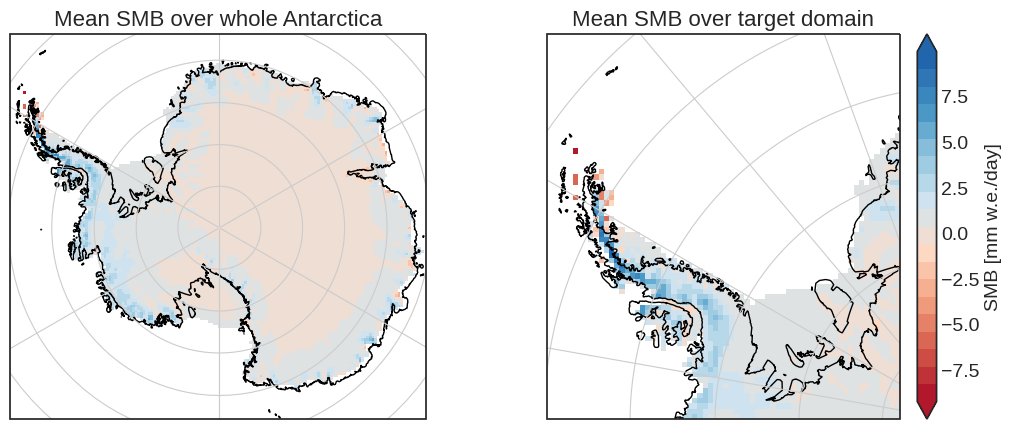

In [11]:
fig = plt.figure(figsize=(12, 5))

# replace 0 values by NaN:
target_mean = target_dataset.SMB.mean(dim="time")
target_mean_SMB = target_mean.values
target_mean_SMB[target_mean_SMB == 0] = "nan"

target_mean_xr = xr.Dataset(coords=target_mean.coords)
target_mean_xr["SMB"] = xr.Variable(data=target_mean_SMB, dims=target_mean.dims)

# peninusula
dsmean = createLowerInput(target_mean_xr, region="Larsen", Nx=35, Ny=25, print_=False)
dsmean = dsmean.where(dsmean.y > 0, drop=True)

# extreme values of peninsula
ds = createLowerInput(target_dataset, region="Larsen", Nx=35, Ny=25, print_=False)
ds = ds.where(ds.y > 0, drop=True)

print("Extreme SMB:", np.nanmin(ds.SMB.values), np.nanmax(ds.SMB.values))
print("Mean SMB:", np.nanmin(dsmean.SMB.values), np.nanmax(dsmean.SMB.values))

vmin = min(np.nanmin(dsmean.SMB.values), np.nanmin(target_mean_xr.SMB.values))
vmax = max(np.nanmax(dsmean.SMB.values), np.nanmax(target_mean_xr.SMB.values))

# cmap = 'RdYlBu_r'
cmap = "RdBu"
ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
target_mean_xr.SMB.plot(
    x="x",
    ax=ax,
    transform=ccrs.SouthPolarStereo(),
    cmap=cmap_SMB,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
)
ax.coastlines("10m", color="black", linewidth=1)
ax.gridlines()
ax.set_title("Mean SMB over whole Antarctica")


ax = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
im = dsmean.SMB.plot(
    x="x",
    ax=ax,
    transform=ccrs.SouthPolarStereo(),
    cmap=cmap_SMB,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
)
ax.coastlines("10m", color="black", linewidth=1)
clb = fig.colorbar(im, ax=[ax], fraction=0.046, pad=0.04, extend="both")
clb.set_label("SMB [mm w.e./day]")
ax.set_title("Mean SMB over target domain")
ax.gridlines()
plt.savefig("target_domains.pdf")

### Mean SMB over Antarctica and target domain (vertical)



Extreme SMB: -59.094128 30.2133
Mean SMB: -9.207557 9.957155


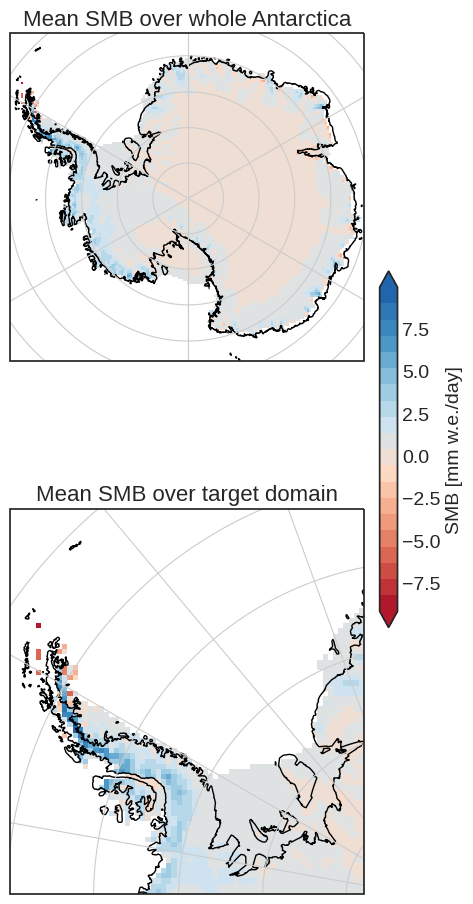

In [12]:
fig = plt.figure(figsize=(5, 12))

# replace 0 values by NaN:
target_mean = target_dataset.SMB.mean(dim="time")
target_mean_SMB = target_mean.values
target_mean_SMB[target_mean_SMB == 0] = "nan"

target_mean_xr = xr.Dataset(coords=target_mean.coords)
target_mean_xr["SMB"] = xr.Variable(data=target_mean_SMB, dims=target_mean.dims)

# peninsula
dsmean = createLowerInput(target_mean_xr, region="Larsen", Nx=35, Ny=25, print_=False)
dsmean = dsmean.where(dsmean.y > 0, drop=True)

# extreme values of peninsula
ds = createLowerInput(target_dataset, region="Larsen", Nx=35, Ny=25, print_=False)
ds = ds.where(ds.y > 0, drop=True)

print("Extreme SMB:", np.nanmin(ds.SMB.values), np.nanmax(ds.SMB.values))
print("Mean SMB:", np.nanmin(dsmean.SMB.values), np.nanmax(dsmean.SMB.values))

vmin = min(np.nanmin(dsmean.SMB.values), np.nanmin(target_mean_xr.SMB.values))
vmax = max(np.nanmax(dsmean.SMB.values), np.nanmax(target_mean_xr.SMB.values))

ax1 = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
target_mean_xr.SMB.plot(
    x="x",
    ax=ax1,
    transform=ccrs.SouthPolarStereo(),
    cmap=cmap_SMB,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
)
ax1.coastlines("10m", color="black", linewidth=1)
ax1.gridlines()
ax1.set_title("Mean SMB over whole Antarctica")


ax = plt.subplot(2, 1, 2, projection=ccrs.SouthPolarStereo())
im = dsmean.SMB.plot(
    x="x",
    ax=ax,
    transform=ccrs.SouthPolarStereo(),
    cmap=cmap_SMB,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
)
ax.coastlines("10m", color="black", linewidth=1)
clb = fig.colorbar(im, ax=[ax, ax1], fraction=0.046, pad=0.04, extend="both")
clb.set_label("SMB [mm w.e./day]")
ax.set_title("Mean SMB over target domain")
ax.gridlines()

### Mean SMB over Antarctica for RCM and GCM resolution

1980-06-30


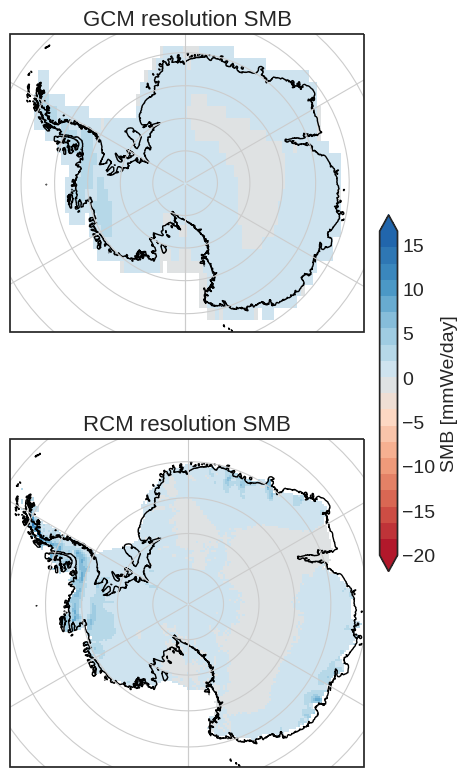

In [13]:
fig = plt.figure(figsize=(5, 10))
var = "SMB"
randTime = 5
dt = pd.to_datetime([UPRCM.time.isel(time=randTime).values])
time = str(dt.date[0])

# replace 0 values by NaN:
# target_mean  = target_dataset[var].mean(dim = 'time')
target_mean = target_dataset[var].isel(time=randTime)
target_mean_SMB = target_mean.values
target_mean_SMB[target_mean_SMB == 0] = "nan"
target_mean_xr = xr.Dataset(coords=target_mean.coords)
target_mean_xr[var] = xr.Variable(data=target_mean_SMB, dims=target_mean.dims)

# replace 0 values by NaN:
input_mean = UPRCM[var].isel(time=randTime)
input_mean_SMB = input_mean.values
input_mean_SMB[input_mean_SMB == 0] = "nan"
input_mean_xr = xr.Dataset(coords=input_mean.coords)
input_mean_xr[var] = xr.Variable(data=input_mean_SMB, dims=input_mean.dims)

vmin = min(np.nanmin(input_mean_xr[var].values), np.nanmin(target_mean_xr[var].values))
vmax = max(np.nanmax(input_mean_xr[var].values), np.nanmax(target_mean_xr[var].values))

ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
im = input_mean_xr.SMB.plot(
    x="x",
    ax=ax,
    transform=ccrs.SouthPolarStereo(),
    cmap=cmap_SMB,
    vmin=-20,
    vmax=vmax,
    add_colorbar=False,
)
ax.coastlines("10m", color="black", linewidth=1)
ax.set_title(f"GCM resolution SMB")
ax.gridlines()

ax2 = plt.subplot(2, 1, 2, projection=ccrs.SouthPolarStereo())
target_mean_xr.SMB.plot(
    x="x",
    ax=ax2,
    transform=ccrs.SouthPolarStereo(),
    cmap=cmap_SMB,
    vmin=-20,
    vmax=vmax,
    add_colorbar=False,
)
ax2.coastlines("10m", color="black", linewidth=1)
ax2.gridlines()
ax2.set_title(f"RCM resolution SMB")
clb = fig.colorbar(im, ax=[ax, ax2], fraction=0.046, pad=0.04, extend="both")
clb.set_label("SMB [mmWe/day]")
print(time)

### RCM truth:

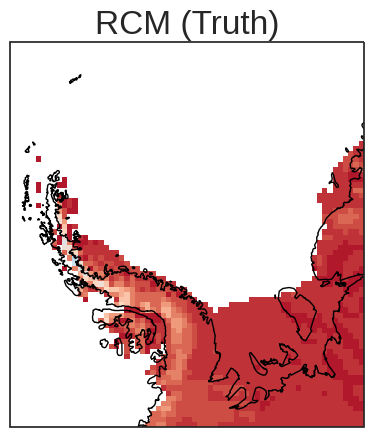

In [14]:
fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
im = dsmean.SMB.plot(
    x="x",
    ax=ax,
    transform=ccrs.SouthPolarStereo(),
    cmap=cmap_SMB,
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False,
)
ax.coastlines("10m", color="black", linewidth=1)
ax.set_title("RCM (Truth)", fontsize=24)
# ax.gridlines()
plt.savefig("Rcmtruth.pdf")


## Create test data:

In [15]:
# difference between both
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))


# variables in UPRCM
all_vars_RCM = sorted(list(UPRCM.data_vars))
all_vars_GCM = sorted(list(GCM.data_vars))

# variables we want to train on:
vars = ["PR", "SP", "LWD", "SWD", "TT", "EW", "NW", "QQP"]

print("Variables in UPRCM:", all_vars_RCM)
print("Variables in GCM:", sorted(list(GCM.data_vars)))
print("Variables to drop in UPRCM:", Diff(all_vars_RCM, vars))
print("Variables to drop in GCM:", Diff(all_vars_GCM, vars))

Variables in UPRCM: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'RF', 'SF', 'SMB', 'SP', 'SWD', 'TT', 'TTP']
Variables in GCM: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'RH', 'SP', 'SWD', 'TT']
Variables to drop in UPRCM: ['TTP', 'SMB', 'SF', 'RF']
Variables to drop in GCM: ['RH']


In [16]:
# Parameters used in training
REGION = "Larsen"
LOSS_ = "NRMSE"
TYPENET = "Attention"
REGIONS = [REGION]

trainingParam = dict(
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    seed=SEED,
    amp=False,
    test_percent=TEST_PERCENT,
    val_percent=VAL_PERCENT,
    loss_=LOSS_,
    typeNet=TYPENET,
)

#### Target:

Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)


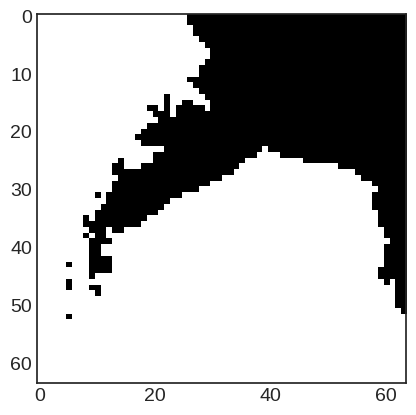

In [17]:
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)

mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

### Inputs:
Global-scale (coarse) variables at GCM resolution.

#### UPRCM:
(Perfect model framework) 

In [18]:
# UPRCM input:
i1D_uprcm, i2D_uprcm, i1D_ns_uprcm, i2D_ns_uprcm, VAR_LIST = make_inputs(
    UPRCM=UPRCM,
    GCM=None,
    size_input_domain=SIZE_INPUT_DOMAIN,
    Region=REGION,
    dropvarGCM=None,
    dropvarRCM=["RF", "SF", "TTP"],
)

# Full input to model:
full_input_uprcm = [
    np.concatenate([i2D_uprcm], axis=0),
    np.concatenate([i1D_uprcm], axis=0),
]
# Non standardised version for plots:
full_input_ns_uprcm = [
    np.concatenate([i2D_ns_uprcm], axis=0),
    np.concatenate([i1D_ns_uprcm], axis=0),
]

# Test set from UPRCM: 
print('Creating UPRCM dataset:\n------------------')
train_set_UPRCM, test_set_UPRCM, net_UPRCM = trainFlow(
    full_input_uprcm,
    full_target,
    mask,
    region=REGION,
    regions = REGIONS,
    train=False,
    randomSplit=False,
    **trainingParam,
)

Creating UPRCM dataset:
------------------


#### GCM:
(Imperfect model framework) 

In [19]:
# GCM input
i1D_GCM, i2D_GCM, i1D_ns_GCM, i2D_ns_GCM, VAR_LIST = make_inputs(
    UPRCM=UPRCM,
    GCM=GCM,
    size_input_domain=SIZE_INPUT_DOMAIN,
    Region=REGION,
    dropvarGCM=None,
    dropvarRCM=["RF", "SF", "TTP"],
)
full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]

# Non standardised version for plots:
full_input_ns_GCM = [
    np.concatenate([i2D_ns_GCM], axis=0),
    np.concatenate([i1D_ns_GCM], axis=0),
]

# Test set from GCM: 
print('Creating GCM dataset:\n------------------')
train_set_GCM, test_set_GCM, net_GCM = trainFlow(
    full_input_GCM,
    full_target,
    mask,
    region=REGION,
    regions = REGIONS,
    train=False,
    randomSplit=False,
    **trainingParam,
)

Creating GCM dataset:
------------------


## Load saved models:

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load saved models
today = str(date.today())

modelUPRCM = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}_UPRCM.pth"
modelGCM = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}_GCM.pth"
modelBaseline = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_Basic_NRMSE_UPRCM.pth"

downloadModel = True

if downloadModel:
    # Download from google drive
    print("Loading UPRCM-Attention model:")
    # Name: MODEL_2022-07-01_Larsen_30_100_Attention_NRMSE
    idModel = '1qbHY2qva7rJtXgrjurtyopmsxjnZ3evl'
    #idModel = '1pJq4zCX_3fILs9Fcs09jWLOZ9mLJXSWr'
    downloaded = Googledrive.CreateFile({"id": idModel})
    downloaded.GetContentFile(modelUPRCM)
    print('Done!')

    # Download from google drive
    print("Loading GCM-Attention model")
    # Name: MODEL_2022-07-01_Larsen_40_100_Attention_NRMSE
    idModel = '1-2rP3wj71ouH2JNae-kQe7sW4Z0u0BXa'
    #idModel = '11JYq0F7AmmFkgjZIEqQKFfQehZz2zM7S'
    downloaded = Googledrive.CreateFile({"id": idModel})
    downloaded.GetContentFile(modelGCM)
    print('Done!')

    """# Download from google drive
    print("Loading NRMSE-basic model")
    # Name: MODEL_2022-07-14_Larsen_50_100_Baseline_NRMSE.pth
    idModel = '1-JbEuI-GUL_70VDrk5aDg_8DvB57l1Rn'
    downloaded = Googledrive.CreateFile({"id": idModel})
    downloaded.GetContentFile(modelBaseline)"""

Loading UPRCM-Attention model:
Done!
Loading GCM-Attention model
Done!


## Make predictions:

###  Perfect world Model:
Predictions of Emulator trained on UPRCM

In [21]:
%%time
# Predictions on UPRCM
print("Predicting on UPRCM dataset:\n------------------")
(   preds_Larsen_NRMSE,
    x_Larsen_NRMSE,
    z_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    r_Larsen_NRMSE,
    loss_mse_UPRCM,
    loss_nrmse_UPRCM,
    loss_rmse_UPRCM,
) = predict(net_UPRCM, device, test_set_UPRCM, modelUPRCM, log_ = False)

# Predictions on GCM
print("Predicting on GCM dataset:\n------------------")
(   preds_Larsen_NRMSE_GCM,
    x_Larsen_NRMSE_GCM,
    z_Larsen_NRMSE_GCM,
    true_smb_Larsen_NRMSE_GCM,
    r_Larsen_NRMSE_GCM,
    loss_mse_GCM,
    loss_nrmse_GCM,
    loss_rmse_GCM,
) = predict(net_GCM, device, test_set_GCM, modelUPRCM, log_ = False)

Predicting on UPRCM dataset:
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting on GCM dataset:
------------------
CPU times: user 13.4 s, sys: 737 ms, total: 14.1 s
Wall time: 15.1 s


###  GCM Model:
Predictions of Emulator trained on GCM

In [22]:
# Predictions on GCM
print("Predicting on GCM dataset:\n------------------")
(   preds_Larsen_NRMSE_GCM_tr,
    x_Larsen_NRMSE_GCM_tr,
    z_Larsen_NRMSE_GCM_tr,
    true_smb_Larsen_NRMSE_GCM_tr,
    r_Larsen_NRMSE_GCM_tr,
    loss_mse_GCM_tr,
    loss_nrmse_GCM_tr,
    loss_rmse_GCM_tr,
) = predict(net_GCM, device, test_set_GCM, modelGCM, log_=False)

Predicting on GCM dataset:
------------------


## Plots:

### Figure 4 - geoplots:

In [27]:
from matplotlib import colors
def plotPredictions3Models(
    preds,
    preds_GCM,
    preds_GCM_tr,
    true_smb,
    r,
    UPRCM,
    target_dataset,
    points_RCM,
    figsize=(15, 5),
    fontsize=14,
    cmap="RdYlBu_r",
    fontsize_axes = 18,
    fontsize_suptitle = 24,
):
    
    fig = plt.figure(figsize=figsize)
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    
    N_rows = 2
    N_cols = 5
    # Random time:
    #randTime = rn.randint(0, len(preds) - 1)
    randTime = 4
    dt = pd.to_datetime([UPRCM.time.isel(time=randTime).values])
    time = str(dt.date[0].strftime("%m/%Y"))
    
    # GCM and RCM over domains
    dsGCM = createLowerInput(UPRCM, region="Larsen", Nx=35, Ny=25, print_=False)
    dsGCM = dsGCM.where(dsGCM.y > 0, drop=True)
    dsRCM = createLowerTarget(
        target_dataset, region="Larsen", Nx=64, Ny=64, print_=False
    )
    
    # samples at that time:
    sampletarget_, samplepred_, samplepredGCM_, samplepredGCM_tr, sampleGCM_ = (
        true_smb[randTime],
        preds[randTime],
        preds_GCM[randTime],
        preds_GCM_tr[randTime],
        np.expand_dims(dsGCM.SMB.isel(time=1).values, 2),
    )
    
    # apply mask over ice/land:
    masktarget = np.expand_dims(createMask(sampletarget_, onechannel=True), 2)
    maskGCM = np.expand_dims(createMask(sampleGCM_, onechannel=True), 2)
    
    # mean values:
    meanGCM = np.expand_dims(dsGCM.SMB.mean(dim="time").values, 2)
    meanTarget = np.array(true_smb).mean(axis=0)
    meanPred = np.array(preds).mean(axis=0)
    meanPredGCM = np.array(preds_GCM).mean(axis=0)
    meanPredGCM_tr = np.array(preds_GCM_tr).mean(axis=0)
    
    # metrics for plots:
    scUPRCM, scGCM,  scGCM_tr, rmseUPRCM, rmseGCM, rmseGCM_tr = metrics_geoplot(
        masktarget, sampletarget_, samplepred_, samplepredGCM_, samplepredGCM_tr, nrmse=False
    )
    
    meanscUPRCM, meanscGCM, meanscGCM_tr, meanrmseUPRCM, meanrmseGCM, meanrmseGCM_tr = metrics_geoplot(
        masktarget, meanTarget, meanPred, meanPredGCM, meanPredGCM_tr, nrmse=False
    )

    sampletarget_ = applyMask(sampletarget_, masktarget)
    samplepred_ = applyMask(samplepred_, masktarget)
    samplepredGCM_ = applyMask(samplepredGCM_, masktarget)
    samplepredGCM_tr = applyMask(samplepredGCM_tr, masktarget)
    sampleGCM_ = applyMask(sampleGCM_, maskGCM)
    
    meanTarget = applyMask(meanTarget, masktarget)
    meanPred = applyMask(meanPred, masktarget)
    meanPredGCM = applyMask(meanPredGCM, masktarget)
    meanPredGCM_tr = applyMask(meanPredGCM_tr, masktarget)
    meanGCM = applyMask(meanGCM, maskGCM)

    # Diff means: 
    diffMeanPred = meanTarget-meanPred
    diffMeanPredGCM = meanTarget-meanPredGCM
    diffMeanPredGCM_tr = meanTarget-meanPredGCM_tr
    
    
    # create xarray for mean GCM smb:
    coords = {"y": dsGCM.coords["y"], "x": dsGCM.coords["x"]}
    GCM_SMB = xr.Dataset(coords=coords, attrs=dsGCM.attrs)
    GCM_SMB["Mean SMB"] = xr.Variable(
        dims=("y", "x"), data=meanGCM[:, :, 0], attrs=dsGCM["SMB"].attrs
    )
    GCM_SMB["SMB"] = xr.Variable(
        dims=("y", "x"), data=sampleGCM_[:, :, 0], attrs=dsGCM["SMB"].attrs
    )

    time = 'May 1980'
    
    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    
    # Random time plots:
    vmin, vmax = getMinMaxCB(sampleGCM_, sampletarget_, samplepred_,samplepredGCM_, samplepredGCM_tr)
    
    #----------------- RCM
    ax1 = plt.subplot(N_rows, N_cols, 1, projection=ccrs.SouthPolarStereo())
    im = plotTarget(
        target_dataset, sampletarget_, ax1, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax1.set_title(f"{time}: RCM (Target)", fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.1f$" % (np.nanmean(sampletarget_),),))
    ax1.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax1.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- GCM
    ax2 = plt.subplot(N_rows, N_cols, 2, projection=ccrs.SouthPolarStereo())
    GCM_SMB.SMB.plot(
        x="x",
        ax=ax2,
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        norm = divnorm
    )
    ax2.coastlines("10m", color="black", linewidth=1)
    ax2.set_title(f"{time}: UPRCM", fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.1f$" % (GCM_SMB.SMB.mean(),),))
    ax2.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax2.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Pred Em(UPRCM) - UPRCM
    ax3 = plt.subplot(N_rows, N_cols, 3, projection=ccrs.SouthPolarStereo())
    im2 = plotPred(
        target_dataset, samplepred_, ax3, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax3.set_title("{}: {}".format(time, '$\mathrm{\operatorname{\hat{F}_{P}(UPRCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join(
        (
            r"$\mathrm{\mu}=%.1f, \mathrm{rmse}=%.2f$"
            % (np.nanmean(samplepred_), rmseUPRCM),
        )
    )
    ax3.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax3.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Pred Em(UPRCM) - GCM
    ax4 = plt.subplot(N_rows, N_cols, 4, projection=ccrs.SouthPolarStereo())
    im2 = plotPred(
        target_dataset, samplepredGCM_, ax4, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax4.set_title("{}: {}".format(time, '$\mathrm{\operatorname{\hat{F}_{P}(GCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join(
        (
            r"$\mathrm{\mu}=%.1f,\mathrm{rmse}=%.2f$"
            % (np.nanmean(samplepredGCM_), rmseGCM),
        )
    )
    ax4.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax4.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Pred Em(GCM) - GCM
    ax5 = plt.subplot(N_rows, N_cols, 5, projection=ccrs.SouthPolarStereo())
    im2 = plotPred(
        target_dataset, samplepredGCM_tr, ax5, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax5.set_title("{}: {}".format(time, '$\mathrm{\operatorname{\hat{F}_{I}(GCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join(
        (
            r"$\mathrm{\mu}=%.1f, \mathrm{rmse}=%.2f$"
            % (np.nanmean(samplepredGCM_tr), rmseGCM_tr),
        )
    )
    ax5.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax5.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    clb = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4, ax5], fraction=0.046, pad=0.04)
    clb.set_label("SMB [mmWe/day]")
    
    """
    for ax in [ax2]:
        for p in points_RCM:
            ax.scatter(
                dsRCM.isel(x=p["x"]).x.values,
                dsRCM.isel(y=p["y"]).y.values,
                marker="x",
                s=100,
                color="red",
            )"""
    
    #----------------- Mean RCM
    # Mean values:
    vmin, vmax = getMinMaxCB(meanGCM, meanTarget, meanPred,meanPredGCM,meanPredGCM_tr)
    
    ax6 = plt.subplot(N_rows, N_cols, 6, projection=ccrs.SouthPolarStereo())
    plotTarget(target_dataset, meanTarget, ax6, vmin, vmax, region="Larsen", cmap=cmap)
    ax6.set_title("Mean: RCM (Target)", fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.1f$" % (np.nanmean(meanTarget)),))
    ax6.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax6.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Mean GCM
    ax7 = plt.subplot(N_rows, N_cols, 7, projection=ccrs.SouthPolarStereo())
    GCM_SMB["Mean SMB"].plot(
        x="x",
        ax=ax7,
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )
    ax7.coastlines("10m", color="black", linewidth=1)
    ax7.set_title(f"Mean: UPRCM", fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.1f$" % (np.nanmean(GCM_SMB["Mean SMB"].values),),))
    ax7.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax7.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Mean Em(UPRCM) - UPRCM
    ax8 = plt.subplot(N_rows, N_cols, 8, projection=ccrs.SouthPolarStereo())
    plotTarget(target_dataset, meanPred, ax8, vmin, vmax, region="Larsen", cmap=cmap)
    ax8.set_title("Mean: {}".format('$\mathrm{\operatorname{\hat{F}_{P}(UPRCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join(
        (
            r"$\mathrm{\mu}=%.1f, \mathrm{rmse}=%.2f$"
            % (np.nanmean(meanPred), meanrmseUPRCM),
        )
    )
    ax8.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax8.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Mean Em(UPRCM) - GCM
    ax9 = plt.subplot(N_rows, N_cols, 9, projection=ccrs.SouthPolarStereo())
    imMean = plotTarget(
        target_dataset, meanPredGCM, ax9, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax9.set_title("Mean: {}".format('$\mathrm{\operatorname{\hat{F}_{P}(GCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join(
        (
            r"$\mathrm{\mu}=%.1f, \mathrm{rmse}=%.2f$"
            % (np.nanmean(meanPredGCM), meanrmseGCM),
        )
    )
    ax9.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax9.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Mean Em(GCM) - GCM
    ax10 = plt.subplot(N_rows, N_cols, 10, projection=ccrs.SouthPolarStereo())
    imMean = plotTarget(
        target_dataset, meanPredGCM_tr, ax10, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax10.set_title("Mean: {}".format('$\mathrm{\operatorname{\hat{F}_{I}(GCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join(
        (
            r"$\mathrm{\mu}=%.1f,  \mathrm{rmse}=%.2f$"
            % (np.nanmean(meanPredGCM_tr), meanrmseGCM_tr),
        )
    )
    ax10.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax10.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    clb = fig.colorbar(imMean, ax=[ax6, ax7, ax8, ax9, ax10], fraction=0.046, pad=0.04)
    clb.set_label("SMB [mmWe/day]")
        
    #plt.suptitle(f"Random month: {time}", fontsize = fontsize_suptitle)

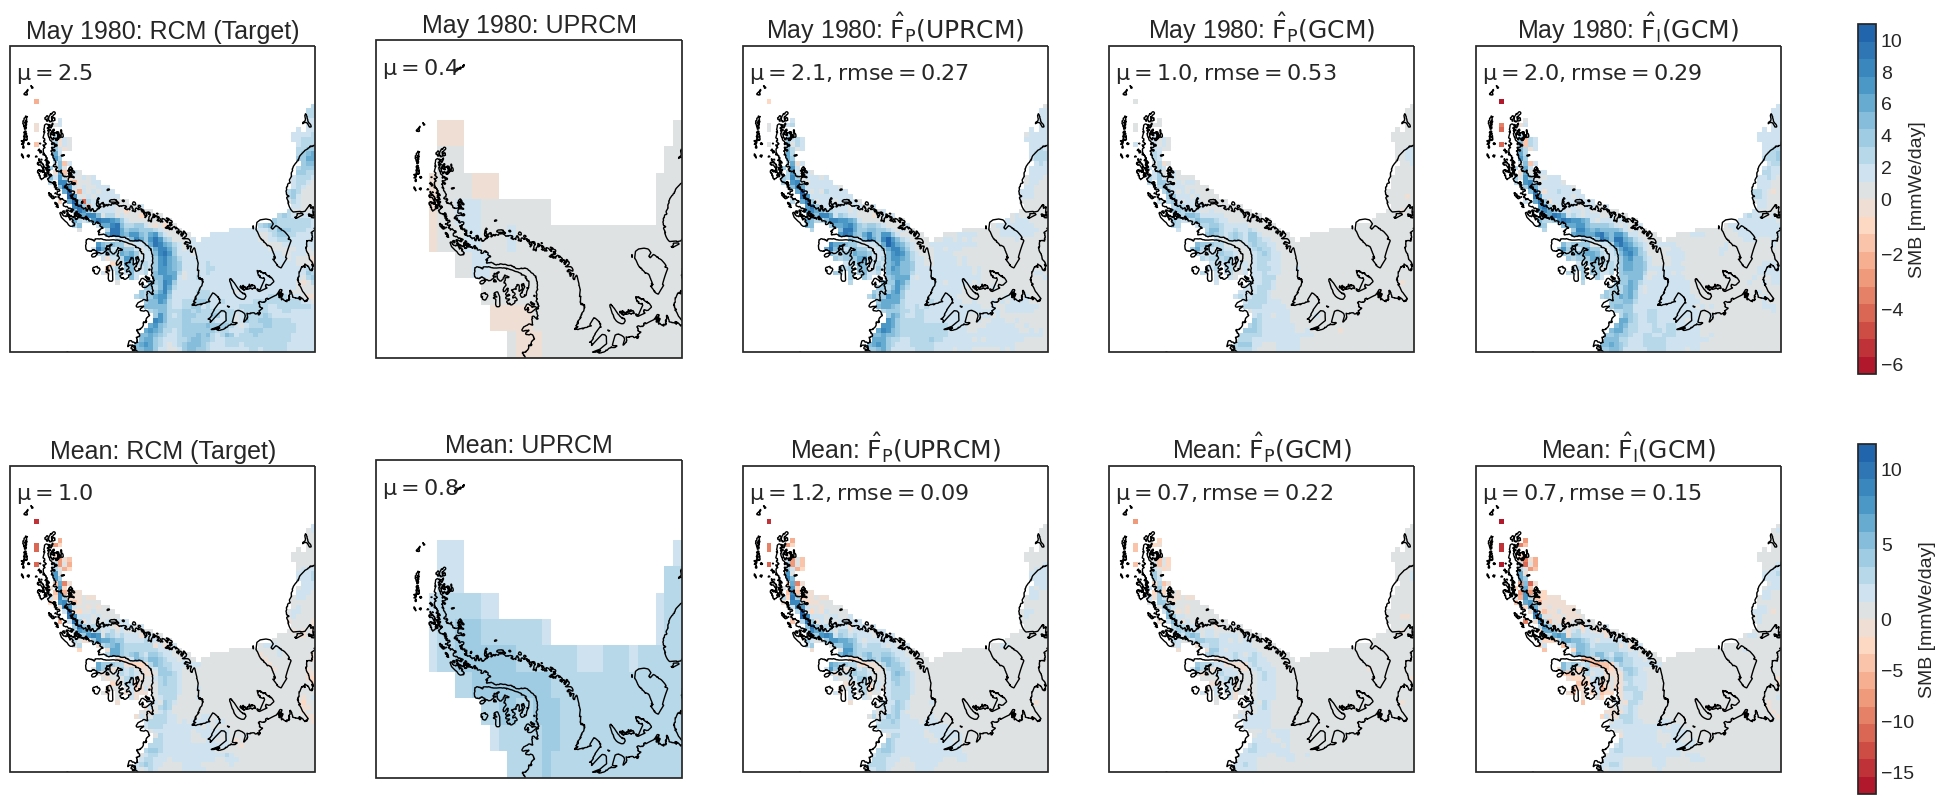

In [28]:
list_colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#fddbc7",
    "#d1e5f0",
    "#92c5de",
    "#4393c3",
    "#2166ac",
]
cmap_name = "my_list"
cmap = LinearSegmentedColormap.from_list(cmap_name, list_colors, N=20)

points_RCM = (
    {"x": 16, "y": 32},
    {"x": 27, "y": 22},
    {"x": 31, "y": 26},
    {"x": 52, "y": 17},
)
plotPredictions3Models(
    preds_Larsen_NRMSE,
    preds_Larsen_NRMSE_GCM,
    preds_Larsen_NRMSE_GCM_tr,
    true_smb_Larsen_NRMSE_GCM,
    r_Larsen_NRMSE_GCM,
    UPRCM,
    target_dataset,
    points_RCM,
    figsize=(25, 10),
    fontsize_axes=18,
    fontsize_suptitle=28,
    # cmap = 'bwr_r'
    cmap=cmap,
)

plt.savefig("geoplots_RCM_GCM.pdf")

In [32]:
def GeoplotsSTDMean(
    preds,
    preds_GCM,
    preds_GCM_tr,
    true_smb,
    r,
    UPRCM,
    target_dataset,
    figsize=(15, 5),
    fontsize=14,
    cmap="RdYlBu_r",
    fontsize_axes = 18,
    fontsize_suptitle = 24,):
  
    fig = plt.figure(figsize=figsize)
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    
    # Random time:
    #randTime = rn.randint(0, len(preds) - 1)
    randTime = 4
    dt = pd.to_datetime([UPRCM.time.isel(time=randTime).values])
    time = str(dt.date[0].strftime("%m/%Y"))
    
    # GCM and RCM over domains
    dsGCM = createLowerInput(UPRCM, region="Larsen", Nx=35, Ny=25, print_=False)
    dsGCM = dsGCM.where(dsGCM.y > 0, drop=True)
    dsRCM = createLowerTarget(
        target_dataset, region="Larsen", Nx=64, Ny=64, print_=False
    )
    
    # samples at that time:
    sampletarget_, samplepred_, samplepredGCM_, samplepredGCM_tr, sampleGCM_ = (
        true_smb[randTime],
        preds[randTime],
        preds_GCM[randTime],
        preds_GCM_tr[randTime],
        np.expand_dims(dsGCM.SMB.isel(time=1).values, 2),
    )
    
    # apply mask over ice/land:
    masktarget = np.expand_dims(createMask(sampletarget_, onechannel=True), 2)
    maskGCM = np.expand_dims(createMask(sampleGCM_, onechannel=True), 2)
    
    # mean values:
    meanGCM = np.expand_dims(dsGCM.SMB.mean(dim="time").values, 2)
    meanTarget = np.array(true_smb).mean(axis=0)
    meanPred = np.array(preds).mean(axis=0)
    meanPredGCM = np.array(preds_GCM).mean(axis=0)
    meanPredGCM_tr = np.array(preds_GCM_tr).mean(axis=0)

    # std values;
    stdTarget = np.array(true_smb).std(axis=0)
    stdPred = np.array(preds).std(axis=0)
    stdPredGCM = np.array(preds_GCM).std(axis=0)
    stdPredGCM_tr = np.array(preds_GCM_tr).std(axis=0)    
    
    # metrics for plots:
    scUPRCM, scGCM,  scGCM_tr, rmseUPRCM, rmseGCM, rmseGCM_tr = metrics_geoplot(
        masktarget, sampletarget_, samplepred_, samplepredGCM_, samplepredGCM_tr, nrmse=False
    )
    
    meanscUPRCM, meanscGCM, meanscGCM_tr, meanrmseUPRCM, meanrmseGCM, meanrmseGCM_tr = metrics_geoplot(
        masktarget, meanTarget, meanPred, meanPredGCM, meanPredGCM_tr, nrmse=False
    )

    sampletarget_ = applyMask(sampletarget_, masktarget)
    samplepred_ = applyMask(samplepred_, masktarget)
    samplepredGCM_ = applyMask(samplepredGCM_, masktarget)
    samplepredGCM_tr = applyMask(samplepredGCM_tr, masktarget)
    sampleGCM_ = applyMask(sampleGCM_, maskGCM)
    
    meanTarget = applyMask(meanTarget, masktarget)
    meanPred = applyMask(meanPred, masktarget)
    meanPredGCM = applyMask(meanPredGCM, masktarget)
    meanPredGCM_tr = applyMask(meanPredGCM_tr, masktarget)
    meanGCM = applyMask(meanGCM, maskGCM)

    stdTarget = applyMask(stdTarget, masktarget)
    stdPred = applyMask(stdPred, masktarget)
    stdPredGCM = applyMask(stdPredGCM, masktarget)
    stdPredGCM_tr = applyMask(stdPredGCM_tr, masktarget)

    # Diff means: 
    diffMeanPred = meanTarget-meanPred
    diffMeanPredGCM = meanTarget-meanPredGCM
    diffMeanPredGCM_tr = meanTarget-meanPredGCM_tr

    # Std means:
    diffStdPred = stdTarget - stdPred
    diffStdPredGCM = stdTarget-stdPredGCM
    diffStdPredGCM_tr = stdTarget-stdPredGCM_tr
    
    divnorm=colors.TwoSlopeNorm(vcenter=0.)

    N_rows = 2
    N_cols = 3

    #----------------- Diff Mean Em(UPRCM) - UPRCM
    vmin = np.nanmin([diffMeanPred, diffMeanPredGCM, diffMeanPredGCM_tr])
    vmax = np.nanmax([diffMeanPred, diffMeanPredGCM, diffMeanPredGCM_tr])
    print(vmin, vmax)
    
    ax1 = plt.subplot(N_rows, N_cols, 1, projection=ccrs.SouthPolarStereo())
    plotTarget(target_dataset, diffMeanPred, ax1, vmin, vmax, region="Larsen", cmap=cmap)
    ax1.set_title("$\overline{RCM}-\overline{\mathrm{\operatorname{\hat{F}_{P}(UPRCM)}}}$", fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.2f$" % (np.nanmean(diffMeanPred),),))
    ax1.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax1.transAxes,
        fontsize=16,
        verticalalignment="top",
    )

    #----------------- Diff Mean Em(UPRCM) - GCM
    ax2 = plt.subplot(N_rows, N_cols, 2, projection=ccrs.SouthPolarStereo())
    imMean = plotTarget(
        target_dataset, diffMeanPredGCM, ax2, vmin, vmax, region="Larsen", cmap=cmap
    )
    
    print(np.nanmean(diffMeanPredGCM))
    ax2.set_title("$\overline{RCM}-\overline{\mathrm{\operatorname{\hat{F}_{P}(GCM)}}}$", fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.2f$" % (np.nanmean(diffMeanPredGCM),),))
    ax2.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax2.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Diff Mean Em(GCM) - GCM
    ax3 = plt.subplot(N_rows, N_cols, 3, projection=ccrs.SouthPolarStereo())
    print(np.nanmean(diffMeanPredGCM_tr))
    imMean = plotTarget(
        target_dataset, diffMeanPredGCM_tr, ax3, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax3.set_title("$\overline{RCM}-\overline{\mathrm{\operatorname{\hat{F}_{I}(GCM)}}}$", fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.2f$" % (np.nanmean(diffMeanPredGCM_tr),),))
    ax3.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax3.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    clb = fig.colorbar(imMean, ax=[ax1, ax2, ax3], fraction=0.046, pad=0.04)

    #----------------- Diff std Em(UPRCM) - UPRCM
    vmin = np.nanmin([diffStdPred, diffStdPredGCM, diffStdPredGCM_tr])
    vmax = np.nanmax([diffStdPred, diffStdPredGCM, diffStdPredGCM_tr])
    print(vmin, vmax)
    
    ax4 = plt.subplot(N_rows, N_cols, 4, projection=ccrs.SouthPolarStereo())
    plotTarget(target_dataset, diffStdPred, ax4, vmin, vmax, region="Larsen", cmap=cmap)
    ax4.set_title("$\sigma$(RCM)-$\sigma$({})".format('$\mathrm{\operatorname{\hat{F}_{P}(UPRCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.2f$" % (np.nanmean(diffStdPred),),))
    ax4.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax4.transAxes,
        fontsize=16,
        verticalalignment="top",
    )

    #----------------- Diff std Em(UPRCM) - GCM
    ax5 = plt.subplot(N_rows, N_cols, 5, projection=ccrs.SouthPolarStereo())
    imMean = plotTarget(
        target_dataset, diffStdPredGCM, ax5, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax5.set_title("$\sigma$(RCM)-$\sigma$({})".format('$\mathrm{\operatorname{\hat{F}_{P}(GCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.2f$" % (np.nanmean(diffStdPredGCM),),))
    ax5.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax5.transAxes,
        fontsize=16,
        verticalalignment="top",
    )
    
    #----------------- Diff std Em(GCM) - GCM
    ax6= plt.subplot(N_rows, N_cols, 6, projection=ccrs.SouthPolarStereo())
    imMean = plotTarget(
        target_dataset, diffStdPredGCM_tr, ax6, vmin, vmax, region="Larsen", cmap=cmap
    )
    ax6.set_title("$\sigma$(RCM)-$\sigma$({})".format('$\mathrm{\operatorname{\hat{F}_{I}(GCM)}}$'), fontsize = fontsize_axes)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.2f$" % (np.nanmean(diffStdPredGCM_tr),),))
    ax6.text(
        0.02,
        0.95,
        textstrBoxplots,
        transform=ax6.transAxes,
        fontsize=16,
        verticalalignment="top",
    )

    clb = fig.colorbar(imMean, ax=[ax4, ax5, ax6], fraction=0.046, pad=0.04)

-8.19236946105957 5.926969528198242
0.3618367125028936
0.3543665867079474
-3.6720290184020996 9.24575662612915


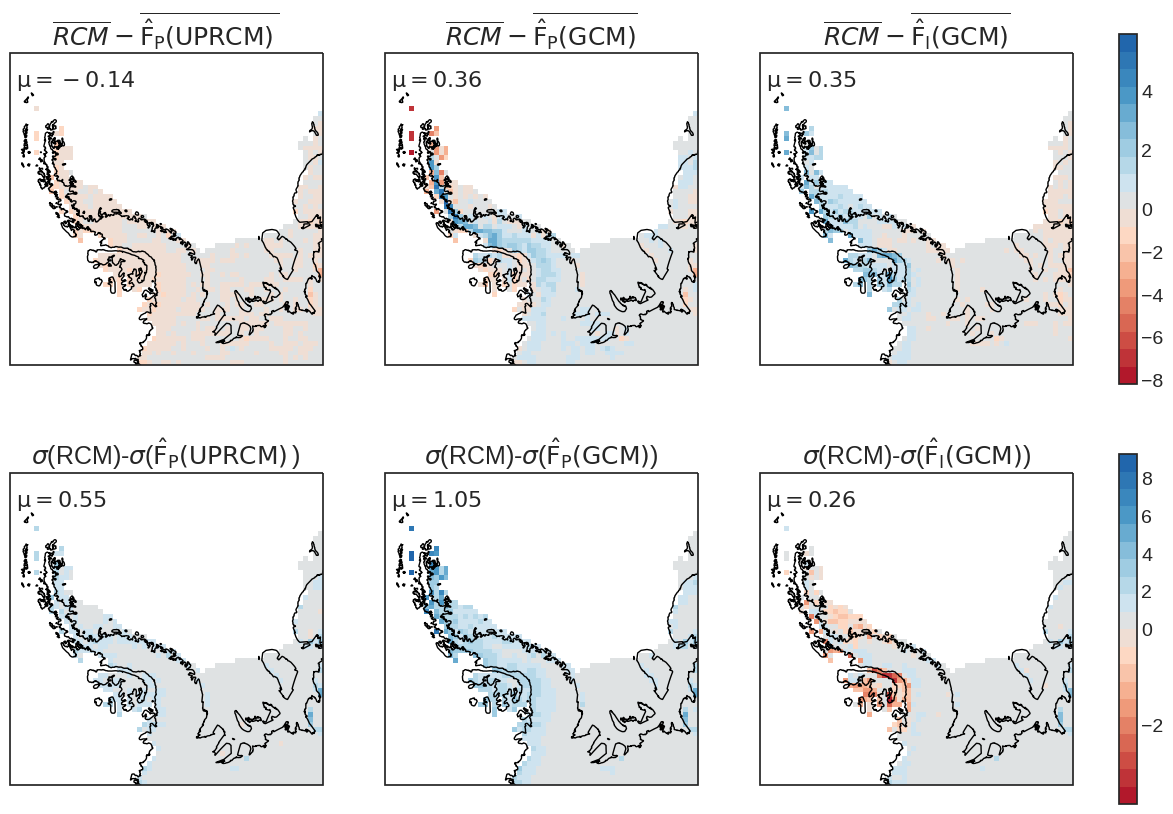

In [33]:
list_colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#fddbc7",
    "#d1e5f0",
    "#92c5de",
    "#4393c3",
    "#2166ac",
]
cmap_name = "my_list"
cmap = LinearSegmentedColormap.from_list(cmap_name, list_colors, N=20)

GeoplotsSTDMean(
    preds_Larsen_NRMSE,
    preds_Larsen_NRMSE_GCM,
    preds_Larsen_NRMSE_GCM_tr,
    true_smb_Larsen_NRMSE_GCM,
    r_Larsen_NRMSE_GCM,
    UPRCM,
    target_dataset,
    figsize=(15, 10),
    fontsize_axes=18,
    fontsize_suptitle=28,
    #cmap = 'bwr_r'
    cmap=cmap,
)

plt.savefig("geoplots_RCM_GCM_std.pdf")

### Figure 5 - evaluation metrics:

In [37]:
metricsUPRCM = calculateMetrics(
    preds_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set_UPRCM,
    REGION,
    ignoreSea=True,
)

metricsGCM = calculateMetrics(
    preds_Larsen_NRMSE_GCM,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set_GCM,
    REGION,
    ignoreSea=True,
)

metricsGCM_tr = calculateMetrics(
    preds_Larsen_NRMSE_GCM_tr,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set_GCM,
    REGION,
    ignoreSea=True,
)

/content/metrics.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  predictions = torch.tensor(preds).clone().detach()
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:42: UserWarning: To copy construct from a tensor, it is recommende

/content/pred_plots_paper.py:390: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_yticklabels([0,0, 0.1, 1, 10], minor=False)
/content/pred_plots_paper.py:461: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels([0,0, 1, 10], minor=False)


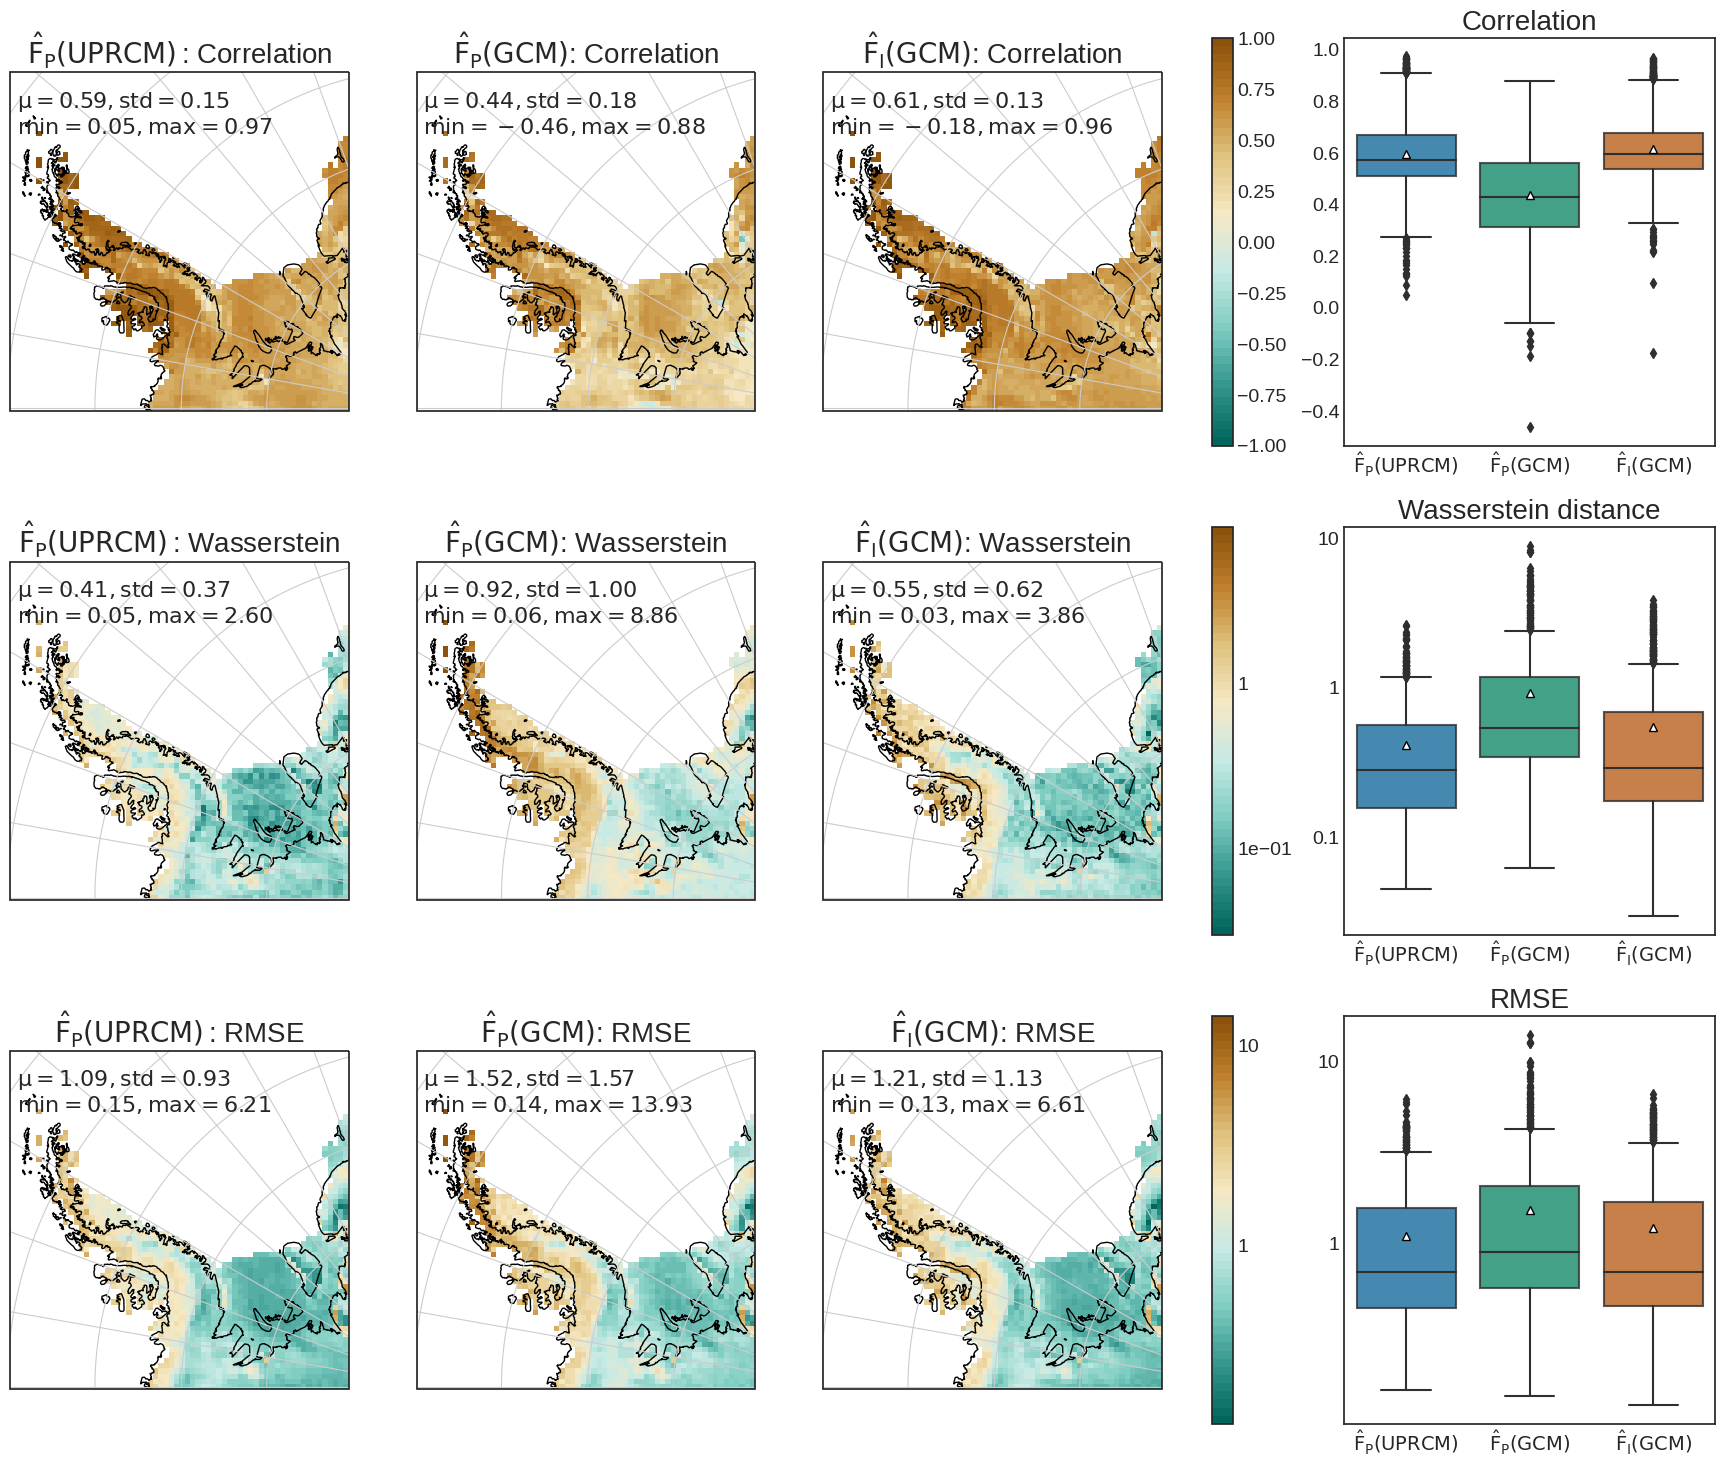

In [38]:
labels = [
    "$\mathrm{\operatorname{\hat{F}_{P}(UPRCM)}}$",
    "$\mathrm{\operatorname{\hat{F}_{P}(GCM)}}$",
    "$\mathrm{\operatorname{\hat{F}_{I}(GCM)}}$",
]

colors = [
    "#8c510a",
    "#bf812d",
    "#dfc27d",
    "#f6e8c3",
    "#c7eae5",
    "#80cdc1",
    "#35978f",
    "#01665e",
][::-1]
cmap_name = "my_list"
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=50)

CompareMetrics3Models(
    PearsonCorr=[
        metricsUPRCM["PearsonCorr"],
        metricsGCM["PearsonCorr"],
        metricsGCM_tr["PearsonCorr"],
    ],
    Wasserstein=[
        metricsUPRCM["Wasserstein"],
        metricsGCM["Wasserstein"],
        metricsGCM_tr["Wasserstein"],
    ],
    RMSE=[metricsUPRCM["RMSE"], metricsGCM["RMSE"], metricsGCM_tr["RMSE"]],
    target_dataset=target_dataset,
    region="Larsen",
    labels=labels,
    figsize=(22, 18),
    cmap=cmap,
)
plt.savefig("evaluation_metrics.pdf")

### Figure 6 - Temporal and spatial correlation:

In [39]:
LarsenUPRCM = createLowerInput(UPRCM, region="Larsen", Nx=48, Ny=25, print_=False)
#LarsenUPRCM = LarsenUPRCM.where(LarsenUPRCM.y > 0, drop=True)
LarsenGCM = createLowerInput(GCM, region="Larsen", Nx=48, Ny=25, print_=False)
#LarsenGCM = LarsenGCM.where(LarsenGCM.y > 0, drop=True)

# Test time:
testTime = LarsenUPRCM.isel(
    time=slice(len(train_set_UPRCM), LarsenUPRCM.dims["time"])
).time.values

# Slice over test period:
LarsenUPRCM = LarsenUPRCM.isel(
    time=slice(len(train_set_UPRCM), LarsenUPRCM.dims["time"])
)
LarsenGCM = LarsenGCM.isel(time=slice(len(train_set_UPRCM), LarsenGCM.dims["time"]))

#### Temporal correlation:

In [40]:
def calculatePearsonWinds(preds, true_smb, ignoreSea=True):
    predictions = torch.tensor(preds).clone().detach()
    target = torch.tensor(true_smb).clone().detach()
    PearsonCorr = np.empty((predictions.shape[1], predictions.shape[2], 1))
    smallCorr, highCorr = [], []
    for i in range(predictions.shape[1]):  # x
        for j in range(predictions.shape[2]):  # y
            pixelPred = predictions[:, i, j, 0].numpy()
            pixelTarg = target[:, i, j, 0].numpy()
            PearsonCorr[i, j] = np.corrcoef(pixelPred, pixelTarg)[0, 1]

            if PearsonCorr[i, j] < 0.3:
                smallCorr.append([pixelPred, pixelTarg])

            if PearsonCorr[i, j] > 0.9:
                highCorr.append([pixelPred, pixelTarg])

    if ignoreSea:
        return PearsonCorr, smallCorr, highCorr
    else:
        # Fill NaN with 0 (uncorrelated)
        PearsonCorr = np.nan_to_num(PearsonCorr)
        return PearsonCorr

In [48]:
def temporalCorr_UPRCM_GCM(
    LarsenUPRCM,
    LarsenGCM,
    UPRCM,
    variables,
    longNames,
    figsize=(15, 6),
    cmap="viridis_r",
):
    fig = plt.figure(figsize=figsize)
    axs, axs2 = [], []
    correlations = {}
    for i, var in enumerate(variables):
        var1 = np.expand_dims(LarsenUPRCM[var].values, 3)
        var2 = np.expand_dims(LarsenGCM[var].values, 3)
        pearson, smallCorr, highCorr = calculatePearsonWinds(var1, var2, ignoreSea=True)

        vmin = np.nanmin(pearson)
        print(vmin)
        correlations[var] = {"small": smallCorr, "high": highCorr}
        ax = plt.subplot(2, 4, i + 1, projection=ccrs.SouthPolarStereo())
        if i + 1 < 5:
            axs.append(ax)
        else:
            axs2.append(ax)

        im = plotPearsonCorr(
            UPRCM,
            pearson,
            ax=ax,
            cmap=cmap,
            mean=np.nanmean(pearson),
            type="GCM",
            colorbar=False,
            vmin=-1,
        )

        ax.set_title("{}".format(longNames[i]), fontsize=14)
        textstrBoxplots = "\n".join(
            (
                r"$\mathrm{\mu}=%.2f$" % (np.nanstd(pearson)),
                r"$\mathrm{std}=%.2f$" % (np.nanstd(pearson)),
                r"$\mathrm{min}=%.2f$" % (np.nanmin(pearson)),
            )
        )
        ax.text(
            0.04,
            0.95,
            textstrBoxplots,
            transform=ax.transAxes,
            fontsize=15,
            verticalalignment="top",
            color="white",
        )

    clb = fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
    clb.set_label("Pearson Correlation")
    clb2 = fig.colorbar(im, ax=axs2, fraction=0.046, pad=0.04)
    clb2.set_label("Pearson Correlation")

    return correlations

In [49]:
from metrics import *

0.9179349079511104
0.9755870050383686
0.92908110440528
0.9786543870638836
0.07865726714053327
-0.19625927752862166
0.475344487512181
0.9570066209986117


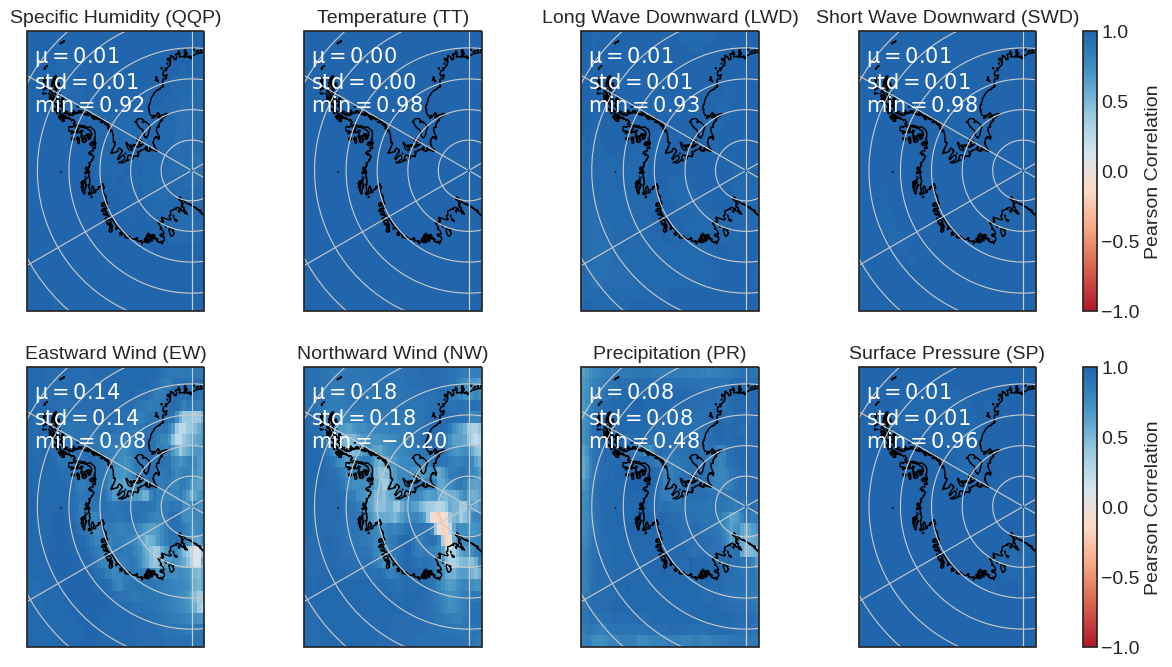

In [50]:
variables = ["QQP", "TT", "LWD", "SWD", "EW", "NW", "PR", "SP"]
# variables = ['SP', 'LWD', 'SWD', 'TT', 'QQP', 'PR', 'NW', 'EW']
longNames = [
    "Specific Humidity (QQP)",
    "Temperature (TT)",
    "Long Wave Downward (LWD)",
    "Short Wave Downward (SWD)",
    "Eastward Wind (EW)",
    "Northward Wind (NW)",
    "Precipitation (PR)",
    "Surface Pressure (SP)",
]
# longNames = ['Surface Pressure', 'Long Wave Downward', 'Short Wave Downward', 'Temperature', 'Specific Humidity', 'Precipitation', 'Northward Wind', 'Eastward Wind']

colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#fddbc7",
    "#d1e5f0",
    "#92c5de",
    "#4393c3",
    "#2166ac",
]
cmap_name = "my_list"
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
correlations = temporalCorr_UPRCM_GCM(
    LarsenUPRCM, LarsenGCM, UPRCM, variables, longNames, figsize=(15, 8), cmap = cmap#cmap='Blues'
)

plt.savefig("Temporal_corr_all.pdf")

#### Spatial correlation:

In [ ]:
def SpatialCorrDF(LarsenGCM, LarsenUPRCM, testTime, list_vars):
    correlations = pd.DataFrame(
        index=testTime,
    )
    for i, var in enumerate(list_vars):
        c_arr = []
        for t in testTime:
            im1 = LarsenGCM[var].sel(time=t).values
            im2 = LarsenUPRCM[var].sel(time=t).values
            c_arr.append(scc(im1, im2))  # spatial correlation
        correlations[var] = c_arr
    return correlations


def getMinMaxCorrVars(vars, correlations):
    minsmax = {}
    minsmaxShort = {}
    for var in vars:
        minvalue = np.abs(correlations[var]).argmin()
        maxvalue = np.abs(correlations[var]).argmax()
        minsmax[var] = [
            correlations.index[minvalue].strftime("%Y-%m-%d"),
            correlations.index[maxvalue].strftime("%Y-%m-%d"),
        ]
        minsmaxShort[var] = [
            correlations.index[minvalue].strftime("%m/%Y"),
            correlations.index[maxvalue].strftime("%m/%Y"),
        ]
    return minsmax, minsmaxShort


def spatialCorr(correlations, figsize=(18, 3)):
    M, N, i = 1, 4, 1
    fig = plt.figure(figsize=figsize)
    colors = ["#0072b2", "#d55e00"]

    min = np.min(correlations.min()) - 0.1
    vars = ["PR", "LWD", "SWD"]
    minsmax, minsmaxShort = getMinMaxCorrVars(vars, correlations)

    ax1 = plt.subplot(M, N, i)
    ax1.plot(correlations.index, correlations["QQP"], label="QQP", c=colors[0])
    ax1.plot(correlations.index, correlations["TT"], label="TT", c=colors[1])
    # ax1.axes.get_xaxis().set_visible(False)

    i += 1
    ax2 = plt.subplot(M, N, i)
    ax2.plot(correlations.index, correlations["LWD"], label="LWD", c=colors[0])
    ax2.plot(correlations.index, correlations["SWD"], label="SWD", c=colors[1])
    ax2.scatter(
        correlations.loc[minsmax["LWD"]]["LWD"].index,
        correlations.loc[minsmax["LWD"]]["LWD"].values,
    )
    ax2.scatter(
        correlations.loc[minsmax["SWD"]]["SWD"].index,
        correlations.loc[minsmax["SWD"]]["SWD"].values,
    )
    # ax2.axes.get_xaxis().set_visible(False)

    i += 1
    ax3 = plt.subplot(M, N, i, sharex=ax1)
    ax3.plot(correlations.index, correlations["EW"], label="EW", c=colors[0])
    ax3.plot(correlations.index, correlations["NW"], label="NW", c=colors[1])

    i += 1
    ax4 = plt.subplot(M, N, i, sharex=ax2)
    ax4.plot(correlations.index, correlations["PR"], label="PR", c=colors[0])

    x = correlations.loc[minsmax["PR"]]["PR"].index
    y = correlations.loc[minsmax["PR"]]["PR"].values
    ax4.scatter(x, y)
    ax4.plot(correlations.index, correlations["SP"], label="SP", c=colors[1])

    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend(loc="upper right", ncol=2)
        ax.set_ylim(top=1, bottom=min)
        ax.grid(axis="y")
        # ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis="x")
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()


/usr/local/lib/python3.10/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float64 and float32
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)


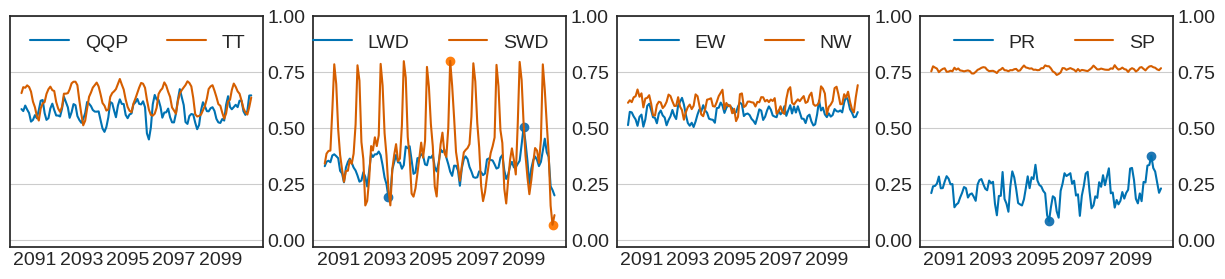

In [ ]:
list_vars = ['SP', 'LWD', 'SWD', 'TT', 'QQP', 'PR', 'NW', 'EW']
correlations =  SpatialCorrDF(LarsenGCM, LarsenUPRCM, testTime, list_vars)
spatialCorr(correlations, figsize = (15, 3))
plt.savefig('Spatial_corr_all.pdf')

/usr/local/lib/python3.10/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)


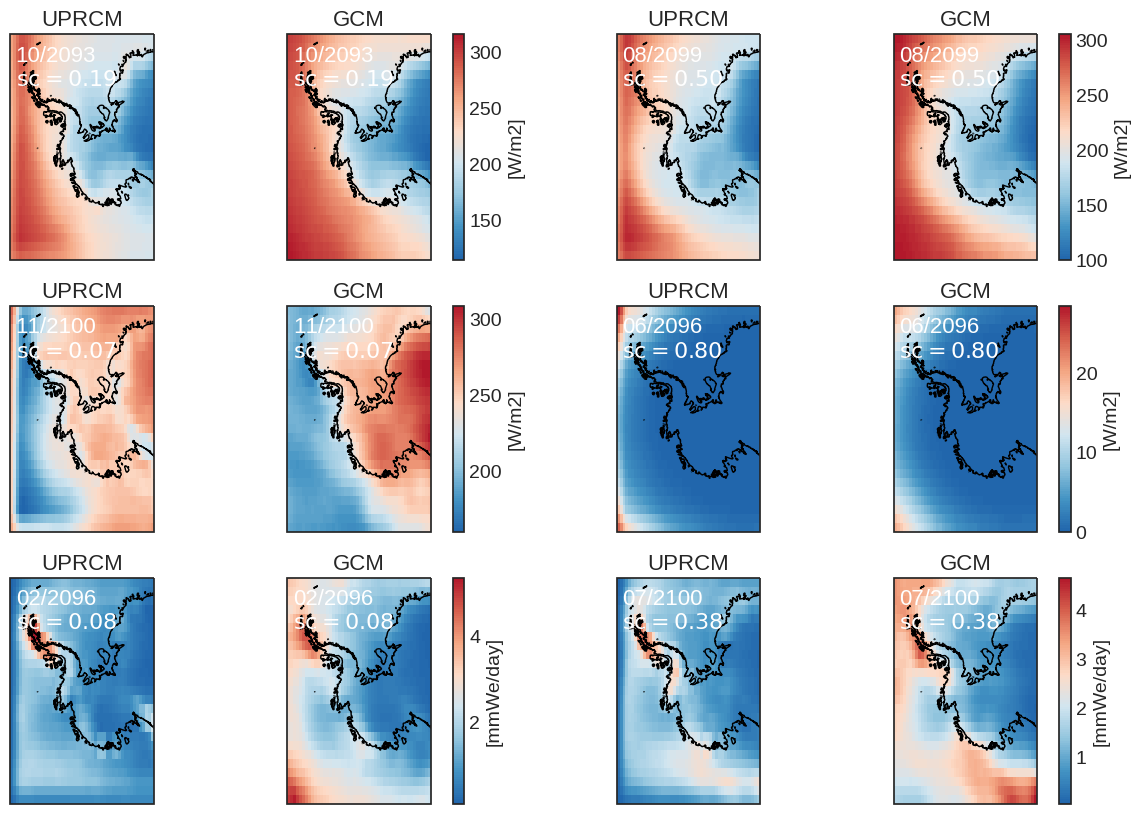

In [ ]:
fig = plt.figure(figsize=(15, 10))
cmap = "viridis"

colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#fddbc7",
    "#d1e5f0",
    "#92c5de",
    "#4393c3",
    "#2166ac",
][::-1]
cmap_name = "my_list"
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)


minsmax, minsmaxShort = getMinMaxCorrVars(vars, correlations)

# --------- LWD -----------
var = "LWD"
# Min:
im1 = LarsenUPRCM[var].sel(time=minsmax[var][0]).values
im2 = LarsenGCM[var].sel(time=minsmax[var][0]).values
ax1 = plt.subplot(3, 4, 1, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenUPRCM[var]
    .sel(time=minsmax[var][0])
    .plot(
        ax=ax1,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax1.set_title(f"UPRCM")

ax2 = plt.subplot(3, 4, 2, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenGCM[var]
    .sel(time=minsmax[var][0])
    .plot(
        ax=ax2,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        cmap=cmap,
        add_colorbar=False,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax2.set_title("GCM")

for ax in [ax1, ax2]:
    textstrBoxplots = "\n".join(
        (f"{minsmaxShort[var][0]}", r"$\mathrm{sc}=%.2f$" % (scc(im1, im2)))
    )
    ax.text(
        0.04,
        0.95,
        textstrBoxplots,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        color="white",
    )
clb = fig.colorbar(cl, ax=[ax1, ax2], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# Max:
im1 = LarsenUPRCM[var].sel(time=minsmax[var][1]).values
im2 = LarsenGCM[var].sel(time=minsmax[var][1]).values

ax3 = plt.subplot(3, 4, 3, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenUPRCM[var]
    .sel(time=minsmax[var][1])
    .plot(
        ax=ax3,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax3.set_title(f"UPRCM")

ax4 = plt.subplot(3, 4, 4, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenGCM[var]
    .sel(time=minsmax[var][1])
    .plot(
        ax=ax4,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax4.set_title("GCM")

for ax in [ax3, ax4]:
    textstrBoxplots = "\n".join(
        (
            f"{minsmaxShort[var][1]}",
            r"$\mathrm{sc}=%.2f$" % (scc(im1, im2)),
        )
    )
    ax.text(
        0.04,
        0.95,
        textstrBoxplots,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        color="white",
    )
clb = fig.colorbar(cl, ax=[ax3, ax4], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# --------- SWD -----------
# Min
var = "SWD"
im1 = LarsenUPRCM[var].sel(time=minsmax[var][0]).values
im2 = LarsenGCM[var].sel(time=minsmax[var][0]).values
ax5 = plt.subplot(3, 4, 5, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenUPRCM[var]
    .sel(time=minsmax[var][0])
    .plot(
        ax=ax5,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax5.set_title(f"UPRCM")

ax6 = plt.subplot(3, 4, 6, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenGCM[var]
    .sel(time=minsmax[var][0])
    .plot(
        ax=ax6,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax6.set_title("GCM")

for ax in [ax6, ax5]:
    textstrBoxplots = "\n".join(
        (
            f"{minsmaxShort[var][0]}",
            r"$\mathrm{sc}=%.2f$" % (scc(im1, im2)),
        )
    )
    ax.text(
        0.04,
        0.95,
        textstrBoxplots,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        color="white",
    )
clb = fig.colorbar(cl, ax=[ax5, ax6], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# Max:
im1 = LarsenUPRCM[var].sel(time=minsmax[var][1]).values
im2 = LarsenGCM[var].sel(time=minsmax[var][1]).values

ax7 = plt.subplot(3, 4, 7, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenUPRCM[var]
    .sel(time=minsmax[var][1])
    .plot(
        ax=ax7,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax7.set_title(f"UPRCM")

ax8 = plt.subplot(3, 4, 8, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenGCM[var]
    .sel(time=minsmax[var][1])
    .plot(
        ax=ax8,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax8.set_title("GCM")

for ax in [ax7, ax8]:
    textstrBoxplots = "\n".join(
        (
            f"{minsmaxShort[var][1]}",
            r"$\mathrm{sc}=%.2f$" % (scc(im1, im2)),
        )
    )
    ax.text(
        0.04,
        0.95,
        textstrBoxplots,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        color="white",
    )
clb = fig.colorbar(cl, ax=[ax7, ax8], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# --------- PR -----------
# Min:
var = "PR"
im1 = LarsenUPRCM[var].sel(time=minsmax[var][0]).values
im2 = LarsenGCM[var].sel(time=minsmax[var][0]).values
ax9 = plt.subplot(3, 4, 9, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenUPRCM[var]
    .sel(time=minsmax[var][0])
    .plot(
        ax=ax9,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax9.set_title(f"UPRCM")

ax10 = plt.subplot(3, 4, 10, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenGCM[var]
    .sel(time=minsmax[var][0])
    .plot(
        ax=ax10,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax10.set_title("GCM")

for ax in [ax9, ax10]:
    textstrBoxplots = "\n".join(
        (
            f"{minsmaxShort[var][0]}",
            r"$\mathrm{sc}=%.2f$" % (scc(im1, im2)),
        )
    )
    ax.text(
        0.04,
        0.95,
        textstrBoxplots,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        color="white",
    )
clb = fig.colorbar(cl, ax=[ax9, ax10], fraction=0.046, pad=0.04)
clb.set_label("[mmWe/day]")

# Max:
im1 = LarsenUPRCM[var].sel(time=minsmax[var][1]).values
im2 = LarsenGCM[var].sel(time=minsmax[var][1]).values

ax11 = plt.subplot(3, 4, 11, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenUPRCM[var]
    .sel(time=minsmax[var][1])
    .plot(
        ax=ax11,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax11.set_title(f"UPRCM")

ax12 = plt.subplot(3, 4, 12, projection=ccrs.SouthPolarStereo())
cl = (
    LarsenGCM[var]
    .sel(time=minsmax[var][1])
    .plot(
        ax=ax12,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        cmap=cmap,
        vmin=np.nanmin([im1, im2]),
        vmax=np.nanmax([im1, im2]),
    )
)
ax12.set_title("GCM")

for ax in [ax11, ax12]:
    textstrBoxplots = "\n".join(
        (
            f"{minsmaxShort[var][1]}",
            r"$\mathrm{sc}=%.2f$" % (scc(im1, im2)),
        )
    )
    ax.text(
        0.04,
        0.95,
        textstrBoxplots,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        color="white",
    )
clb = fig.colorbar(cl, ax=[ax11, ax12], fraction=0.046, pad=0.04)
clb.set_label("[mmWe/day]")

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    ax.coastlines("10m", color="black", linewidth=1)
plt.savefig("Spatial_corr_sample.pdf")

### Figure 7 - timeseries:

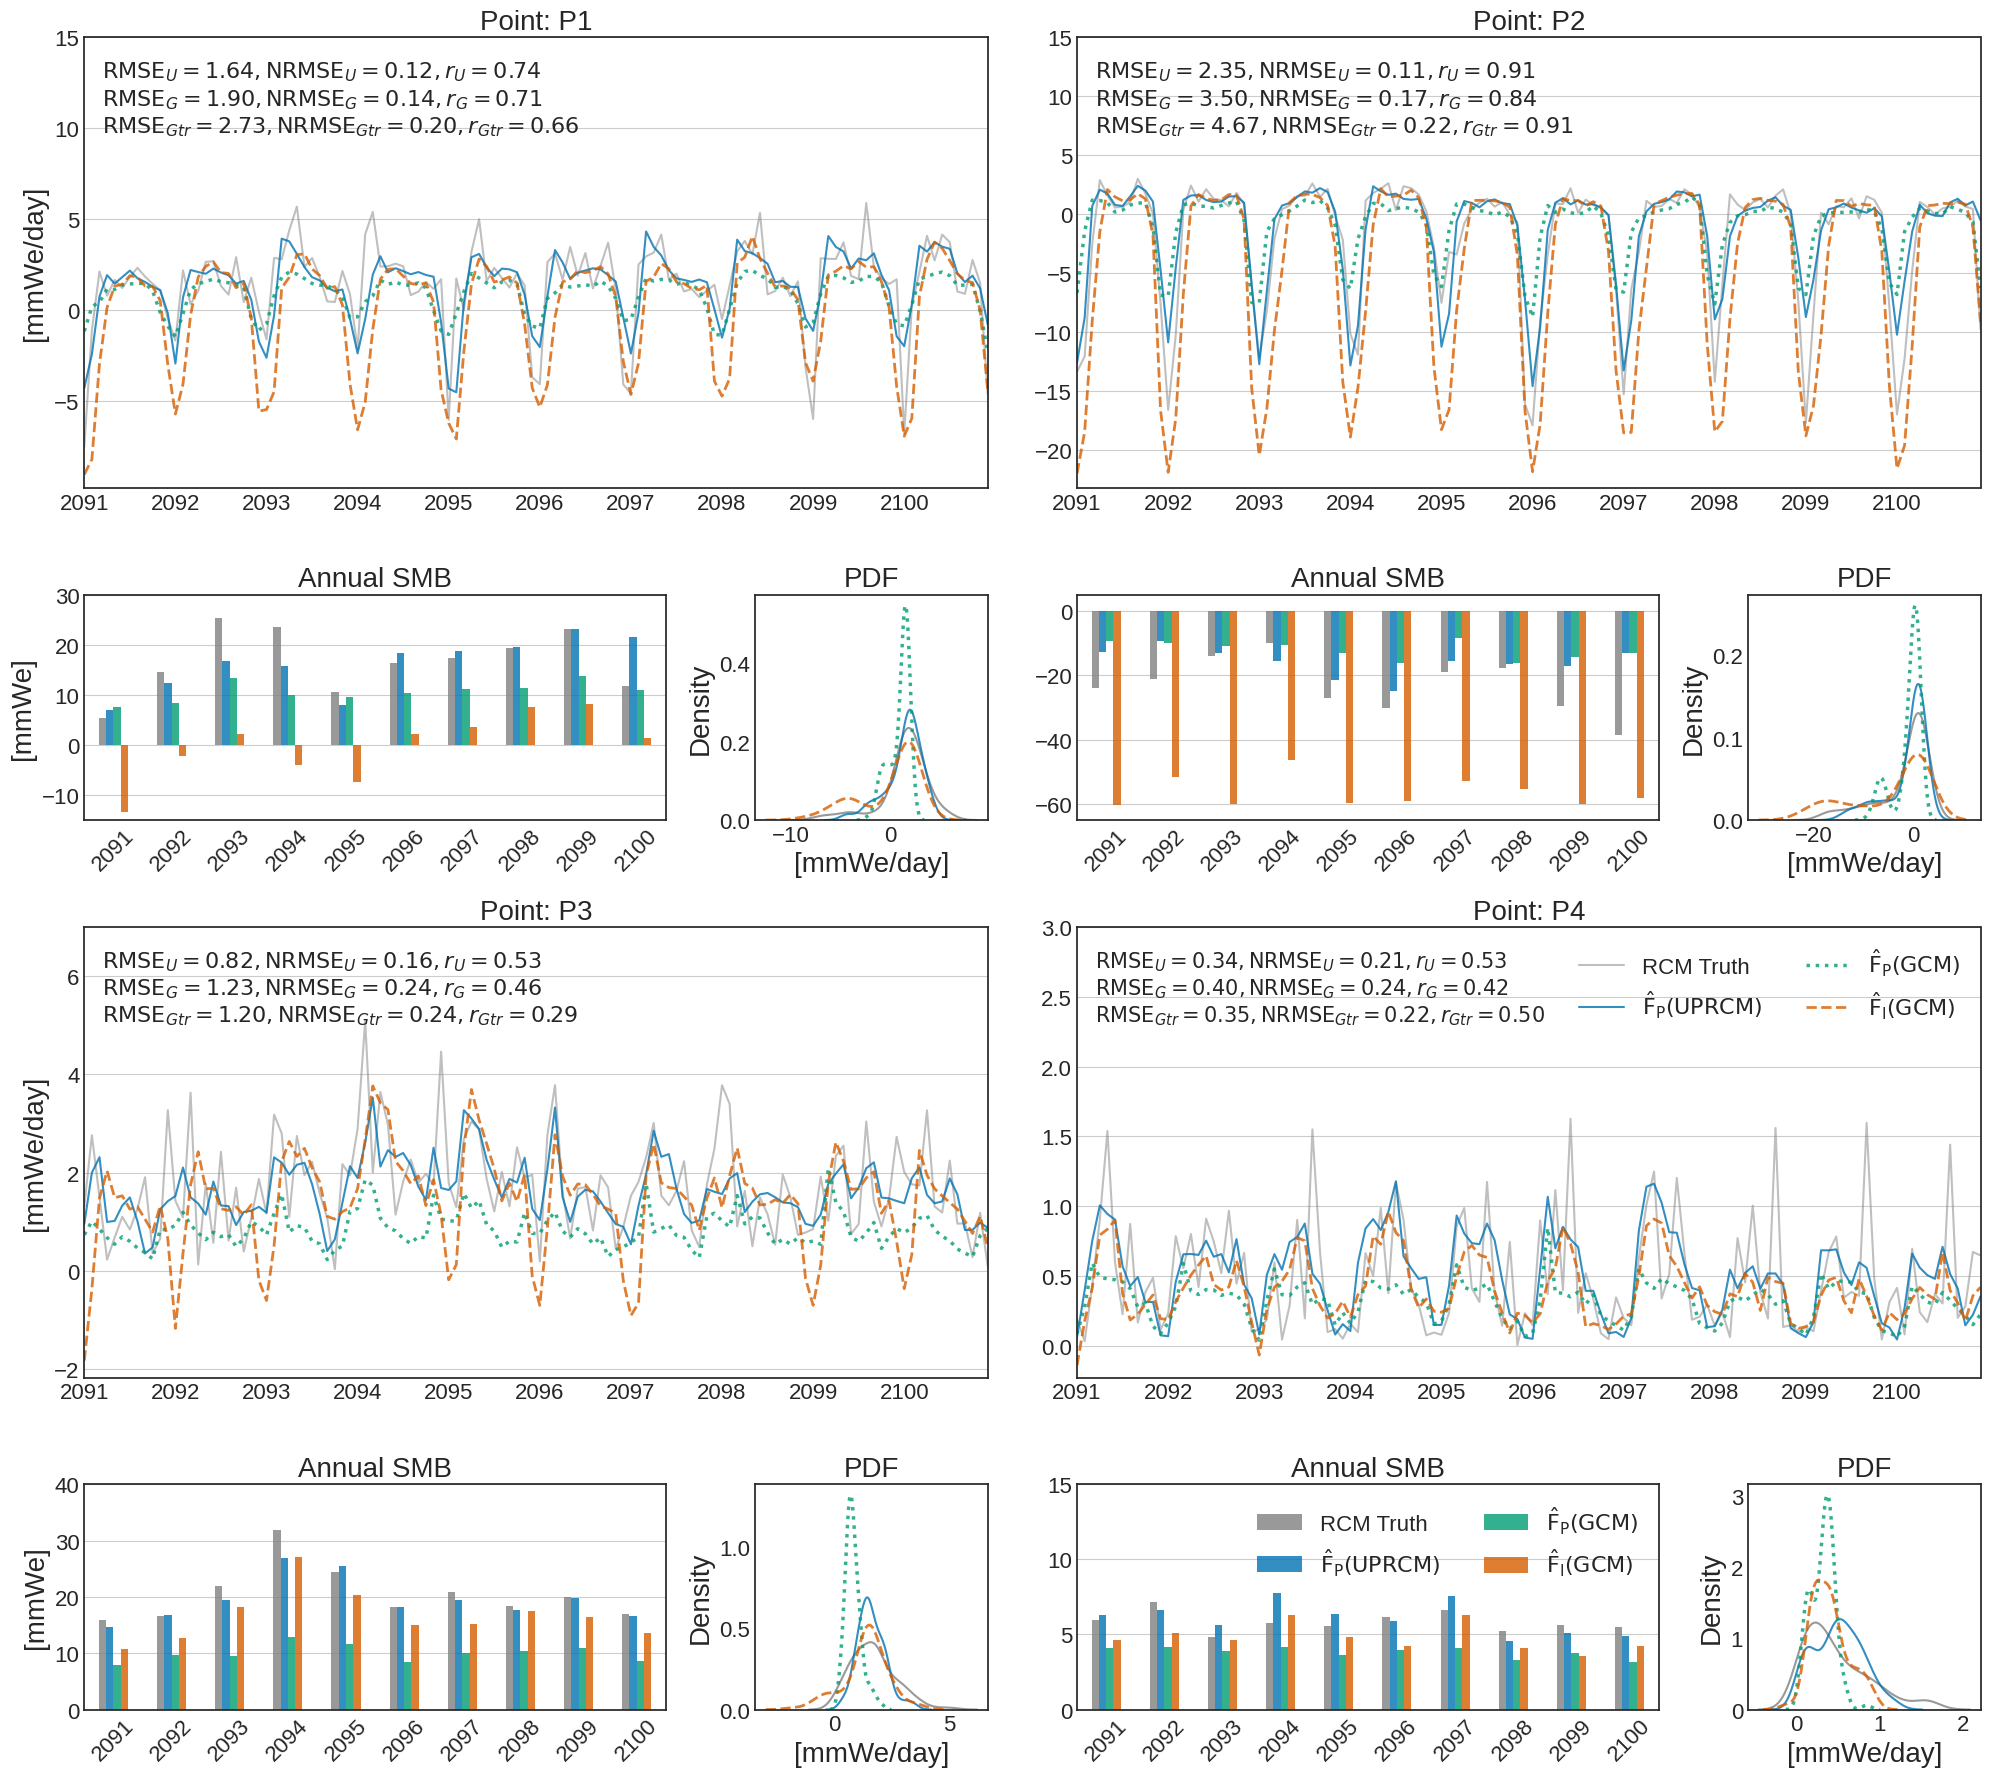

In [ ]:
points_RCM = (
    {"x": 16, "y": 32},
    {"x": 27, "y": 22},
    {"x": 31, "y": 26},
    {"x": 52, "y": 17},
)

labels = [
    "$\mathrm{\operatorname{\hat{F}_{P}(UPRCM)}}$",
    "$\mathrm{\operatorname{\hat{F}_{P}(GCM)}}$",
    "$\mathrm{\operatorname{\hat{F}_{I}(GCM)}}$",
    "RCM Truth",
]
dfPixels = plotTimeseries3Models(
    preds1=preds_Larsen_NRMSE,
    preds2=preds_Larsen_NRMSE_GCM,
    preds3=preds_Larsen_NRMSE_GCM_tr,
    true_smb=true_smb_Larsen_NRMSE,
    train_set=train_set_GCM,
    target_dataset=target_dataset,
    points_RCM=points_RCM,
    region=REGION,
    figsize=(20, 18),
    labels=labels,
    fontsize=24,
)
plt.savefig("timeseries.pdf")
